<a href="https://colab.research.google.com/github/JakeFiler/fromTheGround/blob/main/firstSteps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is to serve as the first real steps into the world of neural networks. The goal of this notebook specifically is to understand how a neural network works at its core, and why it works in that way.

In [ ]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Math Review

In [ ]:
#Quadratic function for a parabola
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
#where x is 3.0 where

f(3.0)

20.0

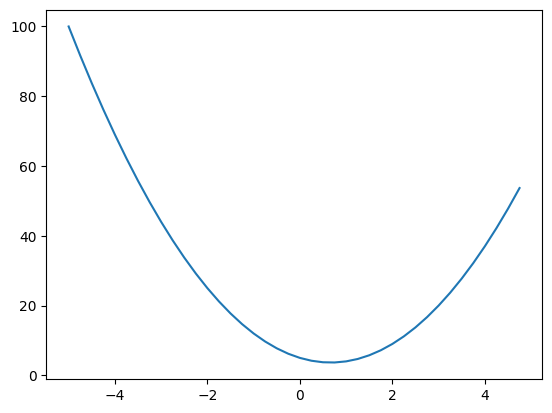

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)




The **derivative** represents the rate of change of a function.

**Differentiation** is the process of finding that derivative.

Below is **numeric differentiation** of a function f(x) where x = 2/3

In [ ]:
h = 0.000000001 # bring this closer to zero and converge to the exact amount (run)
x = 2/3 # the point at which im interested in the derivative of the funciton
f(x+h) # change x an very small amount
f(x+h)-f(x) # what happened to x beacuse of the changes applied by h? (this is the rise)
(f(x+h)-f(x))/h # the approximation of the slope of the tangent line or the IRC(rise/run)

0.0

In [1]:
# A function with mutltiple inputs
h = 0.000000001
a = 2.0
b = -3.0
c = 10.0
d = a*b + c

print(d)

4.0


In [2]:
h = 0.000000001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print(d1)
print(d2)
print((d2 - d1)/h)

4.0
3.9999999969999998
-3.000000248221113


# Value Class

Each operation on a Value (such as addition or multiplication) creates a new Value object that:
- stores the computed result
- keeps track of its parent nodes
- a _backward function that defines how the gradient of the output is distributed to the inputs based on the chain rule


This class encapsulates a single scalar value and its gradient. It also stores:
- `data`: The actual numerical value.
- `grad`: The gradient of the final output with respect to this value (initially `0`).
- `_prev`: A set of parent nodes (used to track dependencies for backprop).
- `_op`: The operation that created this value (`+`, `*`, or `tanh`).
- `_backward`: A function that, when called, applies the chain rule to update gradients of parent nodes.

When we call `backward()` on a final node, it:
1. Builds a topological ordering of the nodes (so we can process them in reverse).
2. Sets the gradient of the final node to 1 (since d(output)/d(output) = 1).
3. Propagates gradients backward through the graph by repeatedly calling `_backward()` on each node.

In [ ]:
'''
The `Value` Class


'''


class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()




In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label ='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

This is giving the children of the d
(value resulting from a*b) and c

In [ ]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

The **operation** used to get the value

In [ ]:
d._op

'+'

# Graphing
Visualizes the computation graph (DAG) used for automatic differentiation

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot



This is the visualization of the **Forward Pass**

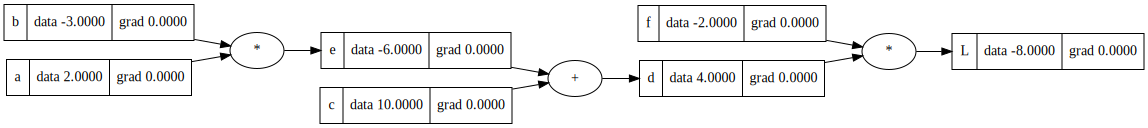

In [ ]:
draw_dot(L)

In [ ]:
#nudging the leaf nodes in some direction to see what happens to L
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print (L.data)

-8.0


#Manual Backpropagation

We want to know the derivitive of d with respect to L

L = d * f view above plot

dL/dd = f the answer

```
the proof
(f(x+h)-f(x))/h
(d+h)*f - d*f / h
df + hf - df / h  -> df-df cancels
hf/h
f

```

Here the derivative of d with respect to L is f

and the derivative of f with respect to L is d


In [ ]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4

In [ ]:
c.grad = -2
e.grad = -2

## Chain Rule Time

If a car is twice as fast as a bike, and a bike is 4 times as fast as a walking man, then the car travels 8 times faster than the man

z = car

y = bicycle

x = man

The rate of change of the relative positions of the car and the walking man is equal to the rate of change of the relative positions of car to the bike times the bike to the man.

dz/dx = dz/dy * dy/dx

2 * 4 = 8

The important part here is how can we get the derivitive of L with respect to c

How is L sensitive to c

If we can figure out how c impacts d, then how d impacts L then we should be able to get it

dd/dc = 1.0

dd/de = 1.0

d = c + e

WANT:

dL / dc = (dL / dd) * (dd/dc)

KNOW:

dL / dd
dd / dc




In [ ]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

dL / de = -2.0

e = a * b

de / da? b

dL / da = (dL / de) * (de / da)


In [ ]:
# Inline Gradient Check
# Deriving the backpropagation and getting the derivative with respect
# to all the intermidiate results
def lol():

  h = 0.00001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label ='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label ='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

lol()

-4.000000000026205


# Activation Functions

Squashing stuff

Your input could be anything form -inf to inf



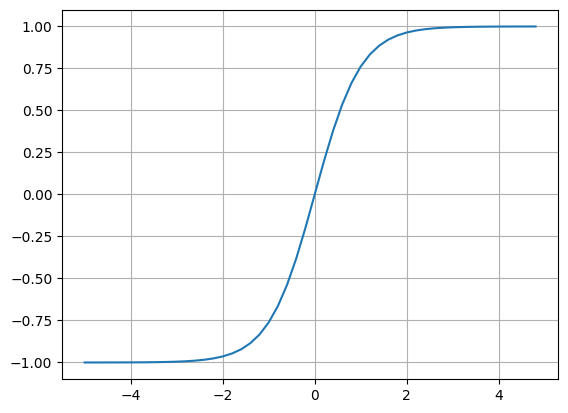

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [ ]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

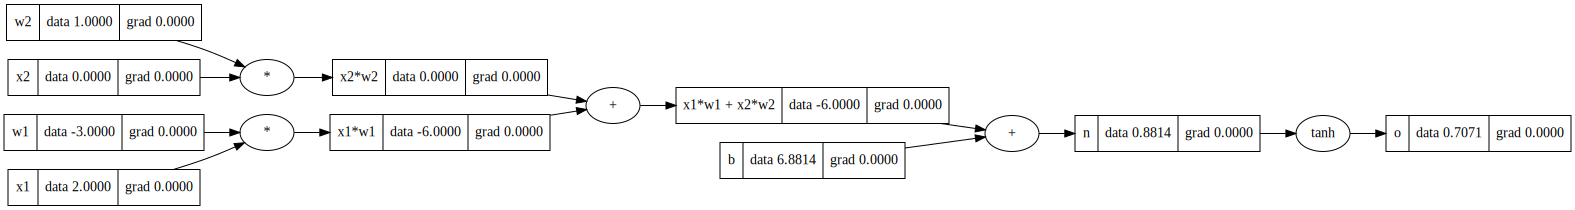

In [ ]:
draw_dot(o)

Run this and recheck graph above to see it backpropagate the gradients through the network

In [ ]:
o.backward()

In [ ]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'

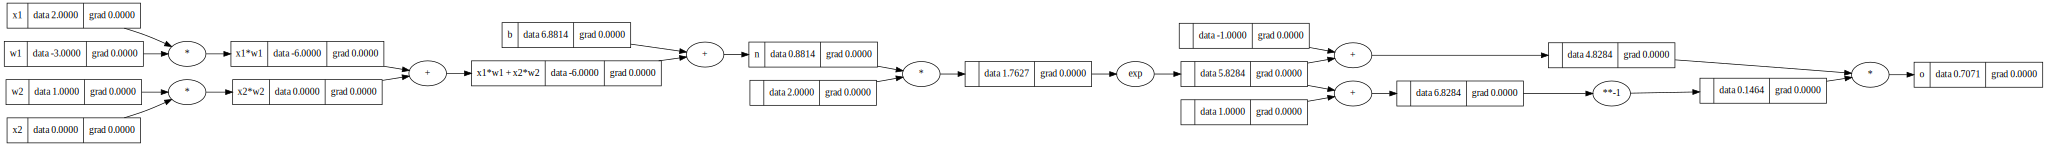

In [ ]:
draw_dot(o)

In [ ]:
o.backward()

In [ ]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]



In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.8562992544989882)

In [ ]:
n.parameters()

[Value(data=-0.416054950203651),
 Value(data=0.5041778869335787),
 Value(data=0.13332357205402934),
 Value(data=0.9967941335024506),
 Value(data=0.4476823086354207),
 Value(data=0.8227035336348103),
 Value(data=-0.00611706883316443),
 Value(data=0.6935325129173984),
 Value(data=-0.8979928983670034),
 Value(data=0.7035356195031084),
 Value(data=-0.8973707094962604),
 Value(data=0.8498138199972924),
 Value(data=-0.18058253571975214),
 Value(data=-0.7467015400828847),
 Value(data=-0.37900761851593145),
 Value(data=0.4474600646810474),
 Value(data=0.6317415885150415),
 Value(data=-0.33099474038936605),
 Value(data=-0.6813566992408078),
 Value(data=-0.024333575894564863),
 Value(data=0.24999483654682209),
 Value(data=0.24805419129239503),
 Value(data=-0.07067855617594909),
 Value(data=0.6058372411227932),
 Value(data=0.9906507108154372),
 Value(data=-0.6336114691786356),
 Value(data=-0.8282976816707512),
 Value(data=-0.516818911535756),
 Value(data=-0.7382101549847475),
 Value(data=-0.69291

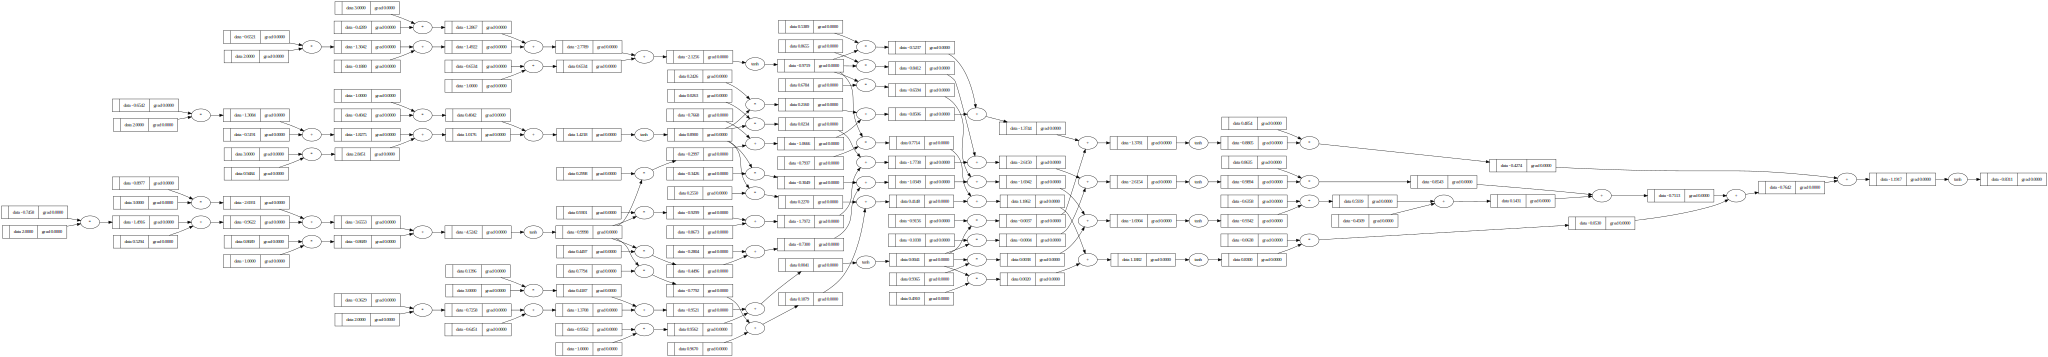

In [ ]:
draw_dot(n(x))

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [ ]:
# Gradient descent training loop
for k in range(25):

  #forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  #backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  #update
  for p in n.parameters():
    p.data += -0.5 * p.grad

  print(k, loss.data)




0 6.307382108625934
1 7.5221804742993115
2 3.7583840006264198
3 0.8409930877831815
4 5.939645268933167
5 0.01732786026142554
6 0.002074573244563368
7 0.0017196214249588114
8 0.00147981898914229
9 0.0013047606079122703
10 0.0011701379204315963
11 0.0010626736340050107
12 0.0009744566899250577
13 0.0009004565121336645
14 0.0008373071599043702
15 0.0007826621298331819
16 0.0007348293357232266
17 0.0006925535671160861
18 0.0006548810920352925
19 0.0006210722202444249
20 0.0005905430131032361
21 0.0005628253302815961
22 0.000537538767466705
23 0.0005143705143627966
24 0.0004930606155951213


In [ ]:
ypred

[Value(data=0.9409457972786073),
 Value(data=-0.9624823485215344),
 Value(data=-0.9332299377073807),
 Value(data=0.945097985188196)]